# Iterative $\alpha$-(de)blending
--------------------------------------
    Alfred PICHARD

## Table of Contents :
### 1. Sinusoidal Positional Encoding
      Implementation of the encoder and plot results
### 2. Diffusion for a 2D point cloud inference problem
      2.1 Simple MLP
      2.2 MLP in UNet with Positional Encoding

In [500]:
### IMOPRTS
%matplotlib inline
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
plt.style.use('dark_background')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

device = "cpu"

## 1. Sinusoidal Positional Encoding

In [255]:
class SinusoidalPositionalEncoder(nn.Module):
    def __init__(self, d_model, max_length=10000):
        super().__init__()
        self.d_model = d_model
        self.max_length = max_length

    def forward(self, x):
        pe = torch.zeros(self.max_length, self.d_model)
        position = torch.arange(0, self.max_length).unsqueeze(1).float()
        omega = torch.exp((torch.arange(0, self.d_model, 2, dtype=torch.float) * -(np.log(1000.0) / self.d_model)))
        pe[:, 0::2] = torch.sin(position * omega)
        pe[:, 1::2] = torch.cos(position * omega)

        x = pe[:x.size(0)]
        return x

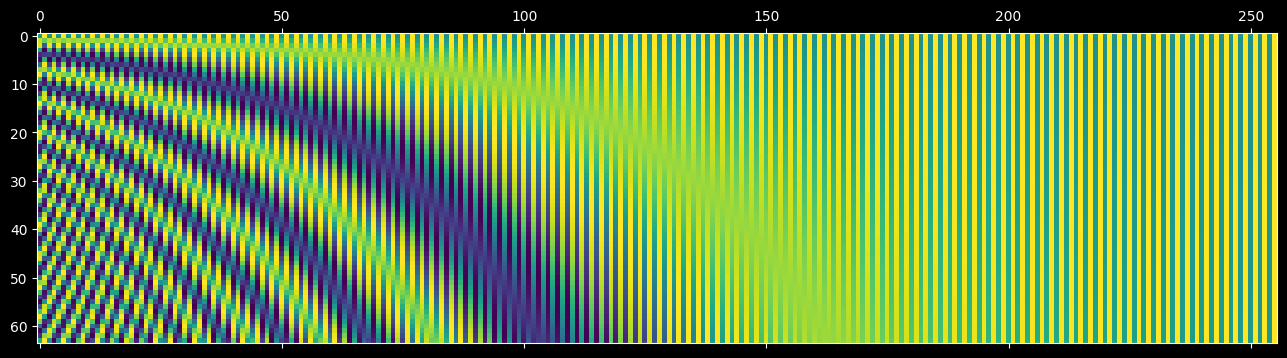

In [256]:
positional_encoder = SinusoidalPositionalEncoder(d_model=256)
tensor = torch.ones(64, 256)

output = positional_encoder(tensor)
plt.matshow(output)


## 2. Diffusion for a 2D point cloud inference problem

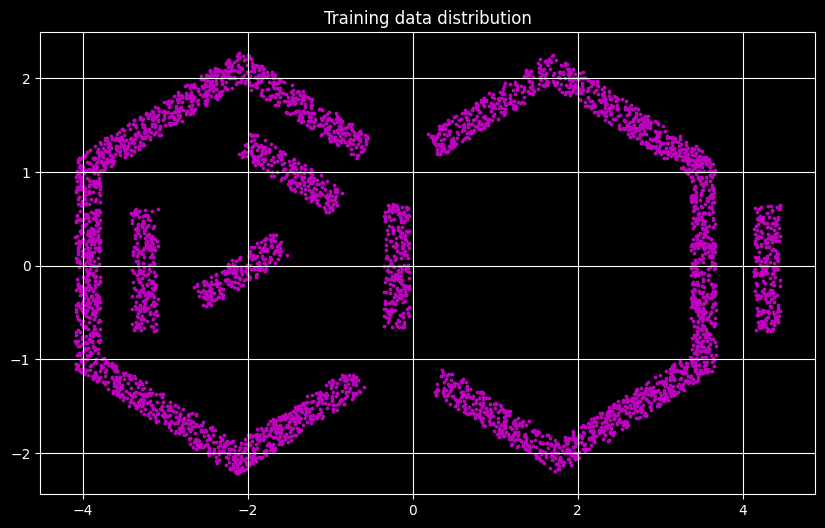

In [446]:
### Data preprocessing
def get_dataset(N = 50000):
    img = mpimg.imread("../../resources/datasets/images/acids.png")

    img = (img * 255).astype(np.uint8)

    img = Image.fromarray(img).convert('L')
    gray_array = np.asarray(img)

    positions = np.random.rand(2, N)
    closest_idx = positions.copy()
    closest_idx[0] *= gray_array.shape[0]
    closest_idx[1] *= gray_array.shape[1]
    closest_idx = closest_idx.astype(int)
    density = np.zeros((N))

    for i in range(N):
        p1 = closest_idx[:, i]
        density[i] = (gray_array[459-p1[1], p1[0]] - 105)/138


    probs = np.random.rand(N)
    positions_final = positions[:,probs>density]    
    return torch.from_numpy(positions_final.T).float()*10-5


data = get_dataset(2**16)

plt.figure(figsize=(10, 6))
plt.scatter(data.T[0], data.T[1], c='m', s=3)
plt.grid()
plt.title("Training data distribution")
plt.show()

In [481]:
### Training loop for alpha-(de)blending which can be used on all 2D point cloud generation models
def train(model, optimizer, criterion, dataset, batch_size):
    permutation = torch.randperm(dataset.size()[0], device=device)
    epoch_loss = 0.
    for i in range(0, dataset.size()[0], batch_size):
        indices = permutation[i:min(dataset.size()[0], i+batch_size)]
        optimizer.zero_grad()
        
        x_1 = dataset[indices]
        x_0 = torch.randn_like(x_1, device=device)
        
        alpha = torch.rand(x_1.size()[0], 1, device=device).float()
        x_alpha = (1-alpha) * x_0 + alpha * x_1

        output = model(x_alpha, alpha)
        target = x_1-x_0

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss

### 1.1 Simple MLP

In [482]:
### Modules Definition
class LinearBlock(nn.Module):
    def __init__(self, hidden_dim, encoder_dim, block_size):
        super().__init__()
        self.dense_hidden = [nn.Linear(hidden_dim + encoder_dim, hidden_dim) for _ in range(block_size)]
        self.activation = nn.SiLU()
    
    def forward(self, x, alpha):
        for layer in self.dense_hidden:
            x = self.activation(layer(torch.cat([x, alpha], dim=1)))

        return x


class AlphaDeblendMLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, encoder_dim):
        super().__init__()
        self.input = nn.Linear(input_dim + encoder_dim, hidden_dim)
        self.linear_block = LinearBlock(hidden_dim, encoder_dim, block_size=3)
        self.output = nn.Linear(hidden_dim + encoder_dim, 2)

        self.positional_encoder = SinusoidalPositionalEncoder(d_model=encoder_dim)
        self.activation = nn.SiLU()
    
    def forward(self, x, alpha):
        alpha = self.positional_encoder(alpha)

        x = self.activation(self.input(torch.cat([x, alpha], dim=1)))
        x = self.linear_block(x, alpha)
        out = self.activation(self.output(torch.cat([x, alpha], dim=1)))
        return out

In [498]:
BATCH_SIZE = 512
EPOCHS = 20001
LR = 0.001

model = AlphaDeblendMLP(input_dim=2, hidden_dim=128, encoder_dim=2)
optimizer = optim.Adam(model.parameters(), lr=LR)
dataset = data
criterion = nn.MSELoss(reduction='mean')

### Train
for epoch in range(EPOCHS):
    epoch_loss = train(model, optimizer, criterion, dataset, BATCH_SIZE)

    if (epoch % 1000 == 0):
        print(f"Loss at epoch {epoch}: {epoch_loss}")

Loss at epoch 0: 55.948405265808105
Loss at epoch 1000: 43.76943111419678
Loss at epoch 2000: 43.096230030059814
Loss at epoch 3000: 43.764036655426025
Loss at epoch 4000: 43.46843099594116
Loss at epoch 5000: 43.54673957824707
Loss at epoch 6000: 44.00097465515137
Loss at epoch 7000: 43.15189576148987
Loss at epoch 8000: 44.47939157485962
Loss at epoch 9000: 43.65932631492615
Loss at epoch 10000: 44.22824764251709
Loss at epoch 11000: 44.310189723968506
Loss at epoch 12000: 44.68263864517212
Loss at epoch 13000: 43.46186828613281
Loss at epoch 14000: 43.87221050262451
Loss at epoch 15000: 43.39401197433472
Loss at epoch 16000: 43.32007646560669
Loss at epoch 17000: 44.13220691680908
Loss at epoch 18000: 42.821598052978516
Loss at epoch 19000: 43.596691608428955
Loss at epoch 20000: 43.83189678192139


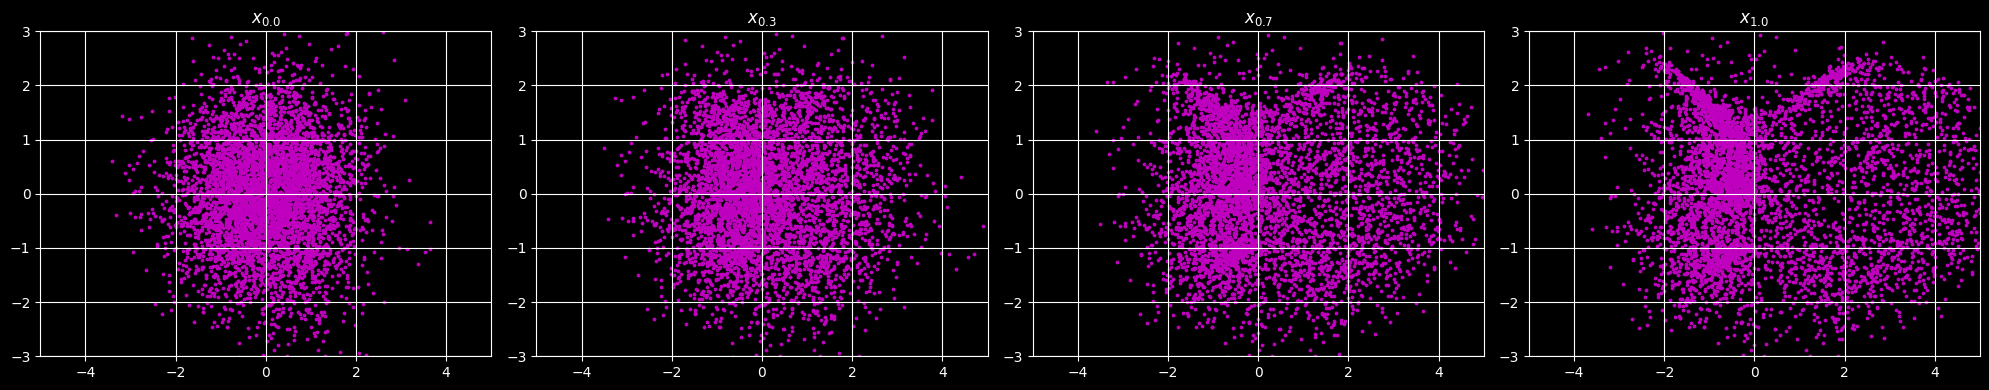

In [499]:
NUM_PLOTS = 3
BATCH_SIZE = 5000
fig, axs = plt.subplots(1, NUM_PLOTS+1, figsize=(20,4))

with torch.no_grad():
    x_alpha = torch.randn(BATCH_SIZE, 2, device=device)

    T = 100
    for t in range(T+1):
        alpha = t/T * torch.ones(BATCH_SIZE, 1)
        x_alpha = x_alpha + (1/T)*model(x_alpha, alpha)

        if (t % (T//NUM_PLOTS) == 0):
            i = t//(T//NUM_PLOTS)
            axs[i].scatter(x_alpha.T[0], x_alpha.T[1], c='m', s=3)
            axs[i].set_title(f"$x_{{{'%.1f'%(alpha[0])}}}$")
            axs[i].set_xlim([-5, 5])
            axs[i].set_ylim([-3, 3])
            axs[i].grid(True)

    fig.tight_layout()
    plt.show()

### 1.2 MLP in UNET with Positional Encoding

In [487]:
### Modules
class Resample(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.resample = nn.Linear(input_dim, output_dim)
        self.activation = nn.SiLU()

    def forward(self, x):
        return self.activation(self.resample(x))


class LinearEncoder(nn.Module):
    def __init__(self, hidden_dims, block_sizes, encoder_dim):
        super().__init__()
        """
        Example with: hidden_dims = [64, 32, 16, 8] & block_sizes = [2, 2, 2]
        linear(64, 64) (x2)
        linear(64, 32)
        linear(32, 32) (x2)
        linear(32, 16)
        linear(16, 16) (x2)
        linear(16, 8)
        """
        self.blocks = [LinearBlock(hidden_dims[k], encoder_dim, block_sizes[k]) for k in range(len(hidden_dims)-1)]
        self.downsamples = [Resample(hidden_dims[k-1], hidden_dims[k]) for k in range(1, len(hidden_dims))]

        self.activation = nn.SiLU()

    def forward(self, x, alpha):
        residuals = []
        for block_id in range(len(self.blocks)):
            x = self.blocks[block_id](x, alpha)
            residuals.append(x)
            x = self.activation(self.downsamples[block_id](x))
        return x, residuals


class LinearDecoder(nn.Module):
    def __init__(self, hidden_dims, block_sizes, encoder_dim):
        super().__init__()
        """
        Example with: hidden_dims = [16, 32, 64], resample_out_dims = [16, 64, 512] & block_sizes = [2, 2, 2]
        upsample : linear(8, 16)
        block : linear(16, 16) (x2)
        cat with residual(16) : result dim (32)

        block : linear(32, 32) (x2)
        cat with residual(32) : result dim (64)

        block : linear(64, 64) (x2)
        cat with residual(64) : result dim (128)
        """
        self.blocks = [LinearBlock(hidden_dims[k], encoder_dim, block_sizes[k-1]) for k in range(len(hidden_dims))]
        self.upsample = Resample(8, 16)

        self.activation = nn.SiLU()

    def forward(self, x, alpha, residuals):
        x = self.activation(self.upsample(x))
        for block_id in range(len(self.blocks)):
            residual = residuals.pop()
            x = torch.cat((self.blocks[block_id](x, alpha), residual), dim=1)

        return x

In [488]:
### UNet
class LinearUNet(nn.Module):
    def __init__(self, input_dim, encoder_dim):
        super().__init__()
        # Input and Output
        self.input = nn.Linear(input_dim+encoder_dim, 64)
        self.output = nn.Linear(128+encoder_dim, 2)

        # Encoder
        self.encoder = LinearEncoder(
            hidden_dims=[64, 32, 16, 8],
            block_sizes=[2, 2, 2],
            encoder_dim=encoder_dim
        )

        # Bottom
        self.bottom = LinearBlock(
            hidden_dim=8,
            encoder_dim=encoder_dim,
            block_size=4
        )

        # Decoder
        self.decoder = LinearDecoder(
            hidden_dims=[16, 32, 64],
            block_sizes=[2, 2, 2],
            encoder_dim=encoder_dim
        )
        
        self.positional_encoder = SinusoidalPositionalEncoder(d_model=encoder_dim)
        self.activation = nn.SiLU()
    
    def forward(self, x, alpha):
        alpha = self.positional_encoder(alpha)

        x = self.activation(self.input(torch.cat([x, alpha], dim=1)))
        
        x, residuals = self.encoder(x, alpha)
        x = self.bottom(x, alpha)
        x = self.decoder(x, alpha, residuals)

        out = self.activation(self.output(torch.cat([x, alpha], dim=1)))

        return out

In [490]:
### Hyperparamerters
BATCH_SIZE = 128
EPOCHS = 1000
LR = 0.001

model = LinearUNet(input_dim=2, encoder_dim=2)
optimizer = optim.Adam(model.parameters(), lr=LR)
dataset = data
criterion = nn.MSELoss(reduction='mean')

### Train
for epoch in range(EPOCHS):
    epoch_loss = train(model, optimizer, criterion, dataset, BATCH_SIZE)

    if (epoch % 100 == 0):
        print(f"Loss at epoch {epoch}: {epoch_loss}")

Loss at epoch 0: 215.4472107887268
Loss at epoch 100: 171.7823884487152
Loss at epoch 200: 169.27771186828613
Loss at epoch 300: 171.96536779403687
Loss at epoch 400: 169.18570137023926
Loss at epoch 500: 171.19428658485413
Loss at epoch 600: 169.68444514274597
Loss at epoch 700: 169.50187993049622
Loss at epoch 800: 168.00606775283813
Loss at epoch 900: 169.97855806350708


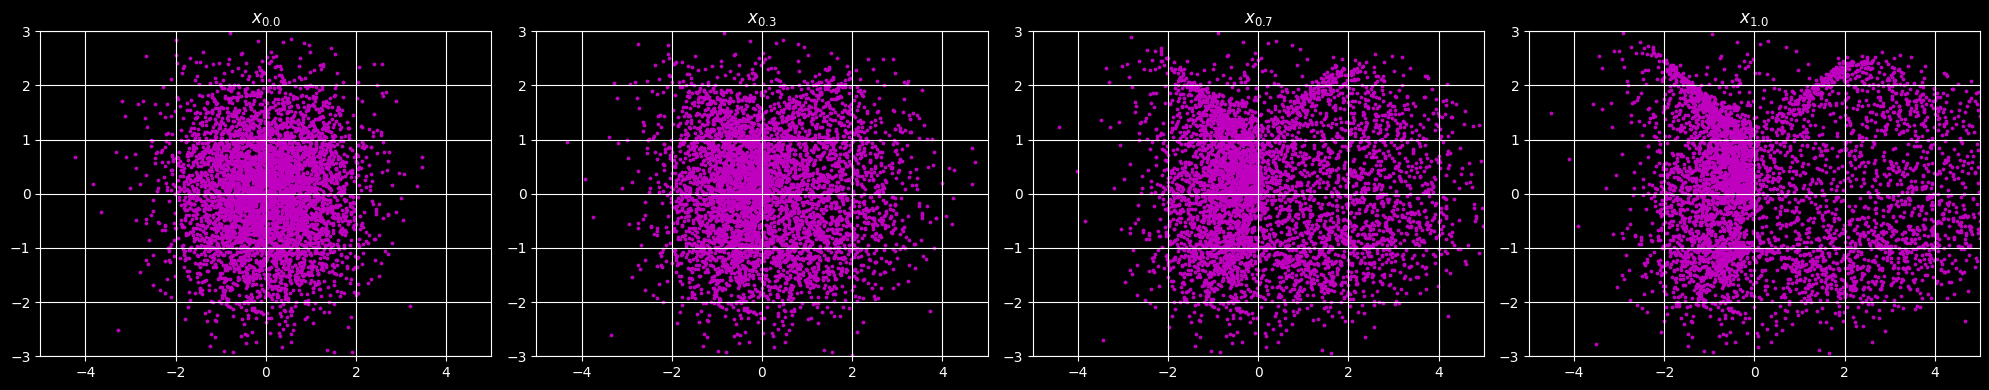

In [501]:
NUM_PLOTS = 3
BATCH_SIZE = 5000
fig, axs = plt.subplots(1, NUM_PLOTS+1, figsize=(20,4))

with torch.no_grad():
    x_alpha = torch.randn(BATCH_SIZE, 2, device=device)

    T = 100
    for t in range(T+1):
        alpha = t/T * torch.ones(BATCH_SIZE, 1)
        x_alpha = x_alpha + (1/T) * model(x_alpha, alpha)

        # Visualize
        if (t % (T//NUM_PLOTS) == 0):
            i = t//(T//NUM_PLOTS)
            axs[i].scatter(x_alpha.T[0], x_alpha.T[1], c='m', s=3)
            axs[i].set_title(f"$x_{{{'%.1f'%(alpha[0])}}}$")
            axs[i].set_xlim([-5, 5])
            axs[i].set_ylim([-3, 3])
            axs[i].grid(True)

    fig.tight_layout()
    plt.show()

## References
- Eric Heitz, Laurent Belcour, and Thomas Chambon. Iterative alpha-(de) blending: a minimalist
deterministic diffusion model. https://arxiv.org/pdf/2305.03486.pdf
- Olaf Ronneberger, Philipp Fischer, and Thomas Brox. U-net: Convolutional networks
for biomedical image segmentation. https://arxiv.org/pdf/1505.04597.pdf